<a href="https://colab.research.google.com/github/sanikamal/tensorflow-AtoZ/blob/master/DCGAN_MNIST_Dataset_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [0]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt
from IPython import display

import numpy as np

import tensorflow as tf
    
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Dropout, Conv2D, Flatten

In [2]:
print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.0.0-alpha0


In [0]:
BUFFER_SIZE = 70000
BATCH_SIZE = 32
NOISE_DIM = 100

# Loading Dataset


In [4]:
(train_images, train_label), (test_images, test_label) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
true_images, true_labels = np.concatenate((train_images, test_images)), np.concatenate((train_label, test_label))

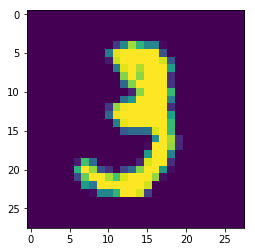

In [7]:
plt.imshow(true_images[10])

In [0]:
true_images_nrm = (true_images[..., tf.newaxis].astype(np.float32)-127.5)/127.5

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(true_images_nrm).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
seed = tf.random.normal([16, NOISE_DIM])

In [0]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Generator Class

In [0]:
class GeneratorModel(tf.keras.Model):
    def __init__(self):
        super(GeneratorModel, self).__init__()
        
        self.dense = Dense(7*7*256, use_bias=False, input_shape=(100,))
        
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.bn3 = BatchNormalization()
        
        self.act1 = LeakyReLU()
        self.act2 = LeakyReLU()
        self.act3 = LeakyReLU()

        self.reshape = Reshape((7, 7, 256))
        
        self.transpose1 = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)
        self.transpose2 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.transpose3 = Conv2DTranspose(1, (5, 5), strides=(2, 2), activation='tanh', padding='same', use_bias=False)
        
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
    def loss(self, pred):
        return tf.compat.v1.losses.sigmoid_cross_entropy(tf.ones_like(pred), pred)
        
    def call(self, x):
        x = self.dense(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.reshape(x)
        
        x = self.transpose1(x)
        x = self.bn2(x)
        x = self.act2(x)
        
        x = self.transpose2(x)
        x = self.bn3(x)
        x = self.act3(x)
        
        return self.transpose3(x)

# Discriminator Class


In [0]:
class DiscriminatorModel(tf.keras.Model):
    def __init__(self):
        super(DiscriminatorModel, self).__init__()
        
        self.conv2d_1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same')
        self.conv2d_2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        
        self.dense = Dense(1)
        
        self.drop1 = BatchNormalization()
        self.drop2 = BatchNormalization()
        
        self.act1 = LeakyReLU()
        self.act2 = LeakyReLU()

        self.flat = Flatten()
        
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
    def loss(self, real, pred):
        return tf.compat.v1.losses.sigmoid_cross_entropy(tf.ones_like(real), real) + tf.compat.v1.losses.sigmoid_cross_entropy(tf.zeros_like(pred), pred)
        
    def call(self, x):
        x = self.conv2d_1(x)
        x = self.act1(x)
        x = self.drop1(x)
        
        x = self.conv2d_2(x)
        x = self.act2(x)
        x = self.drop2(x)
        
        x = self.flat(x)
        return self.dense(x)            

In [0]:
class DCGAN(tf.keras.Model):
    def __init__(self):
        super(DCGAN, self).__init__()
        
        self.discriminator = DiscriminatorModel()
        self.generator = GeneratorModel()
        
    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Create an image using Generator and Random Noise
            gen_pred = self.generator(noise)
            
            # Predict on real images i.e should give 1 always because real
            disc_real_pred = self.discriminator(images)
            
            # Predict on fake images i.e should give 0 always because fake
            disc_fake_pred = self.discriminator(gen_pred)
            
            
            # Loss between our fake image and discriminator capability
            gen_loss = self.generator.loss(disc_fake_pred)
            
            # Loss symbolizing how close real image is to 1 and fake to 0
            disc_loss = self.discriminator.loss(disc_real_pred, disc_fake_pred)
            
            
        grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.generator.optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
        
        grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.discriminator.optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))
        
    def fit(self, images, epochs):
        for epoch in range(epochs):
            for image in images:
                self.train_step(image)
            
            display.clear_output(wait=True)
            print(epoch+1,':')
            generate_and_save_images(self.generator,
                             epoch + 1,
                             seed)

In [0]:
dcgan = DCGAN()

5 :


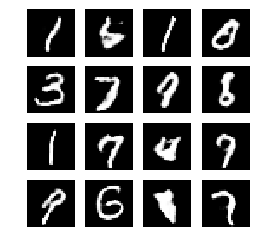

In [18]:
dcgan.fit(train_dataset, 5)